In [1]:
import numpy as np

import itertools
import time

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import NuSVC

from tqdm import tqdm

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn
%matplotlib inline

In [2]:
def create_models(kernels, degrees):
     for k in kernels:
        if k == 'poly':
            for d in degrees:
                model = SVC(kernel=k, degree=d)
                yield k, d, model
        else:
            model = SVC(kernel=k)
            yield k, None, model
        
def plot_polynomial(X_orig, y_train, kernels, degrees=[]):
    x_min, x_max = np.min(X_orig['x']) - 1, np.max(X_orig['x']) + 1
    y_min, y_max = np.min(X_orig['y']) - 1, np.max(X_orig['y']) + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.025),
                         np.arange(y_min, y_max, 0.025))
    
    X_test = np.c_[xx.ravel(), yy.ravel()]
    
    for k, d, model in create_models(kernels, degrees):
        if k == 'poly':
            print 'working with kernel={}, degree={}'.format(k, d)
        else:
            print 'working with kernel={}'.format(k)
            
        model.fit(X_orig, y_train)
        Z = model.predict(X_test)

        score = np.mean(cross_val_score(model, X_orig, y_train, cv=4, n_jobs=4, scoring='accuracy'))

        Z = Z.reshape(xx.shape)
        plt.figure(figsize=(10, 7))
        plt.contourf(xx, yy, Z, alpha=0.4)
        plt.scatter(X_orig[y_train == 0]['x'], X_orig[y_train == 0]['y'], color='red')
        plt.scatter(X_orig[y_train == 1]['x'], X_orig[y_train == 1]['y'], color='blue')
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, edgecolors='black', linewidth='3',facecolors='none', zorder=10)
        if k == 'poly':
            plt.title('kernel=poly, degree={}, accuracy={}'.format(d, score))
        else:
            plt.title('kernel={}, accuracy={}'.format(k, score))

In [12]:
data = pd.read_csv('data/blobs2.csv')

In [4]:
X = data.drop(['label'], axis=1)
y = np.array(data['label'], dtype=int)

working with kernel=linear
working with kernel=rbf
working with kernel=poly, degree=2
working with kernel=poly, degree=3
working with kernel=poly, degree=4
working with kernel=poly, degree=5
working with kernel=poly, degree=6
working with kernel=poly, degree=7
working with kernel=poly, degree=8
working with kernel=poly, degree=9
working with kernel=poly, degree=10


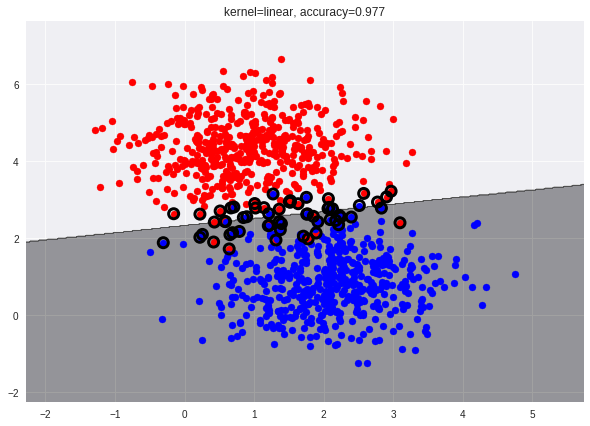

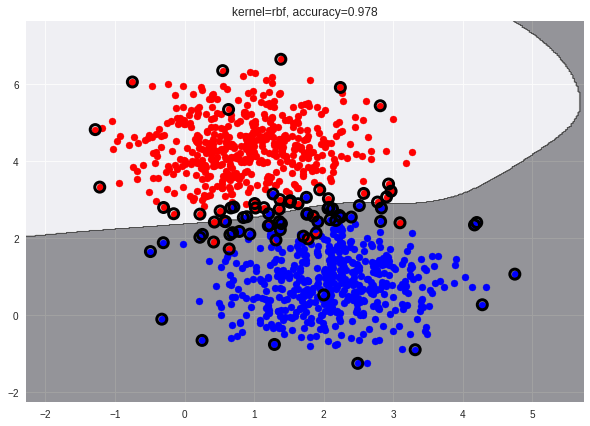

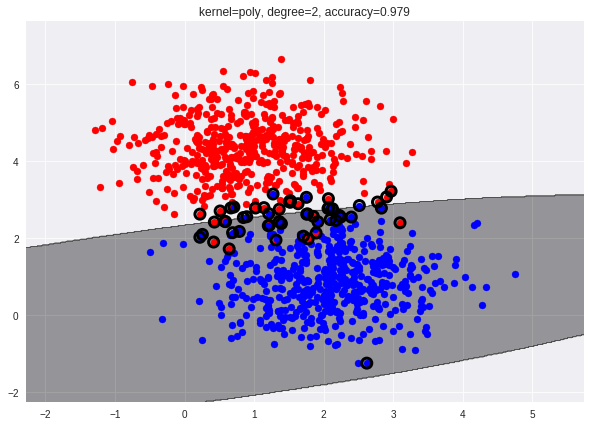

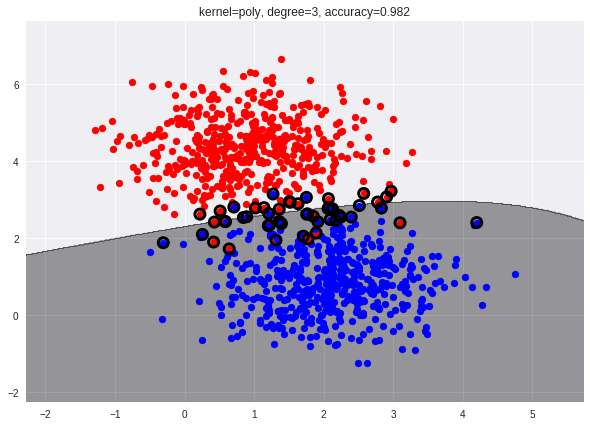

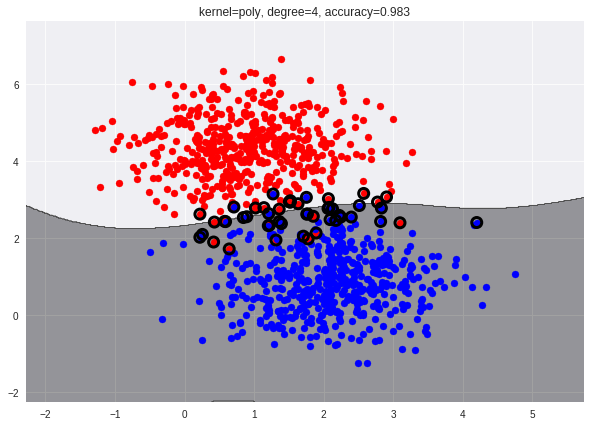

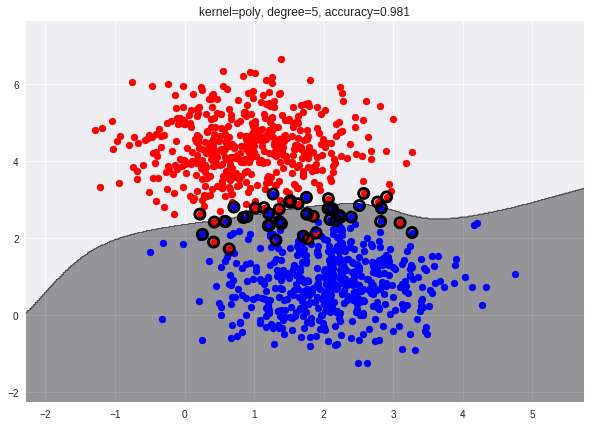

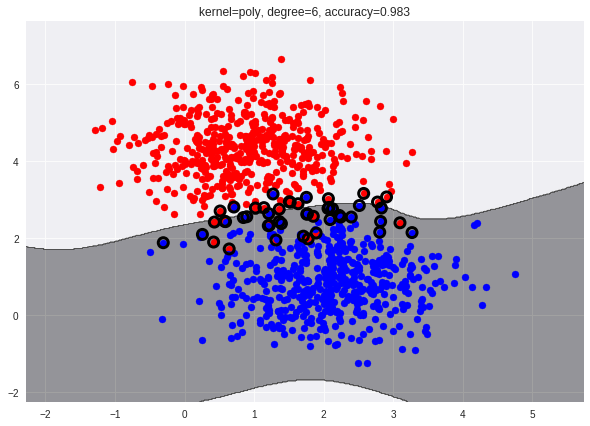

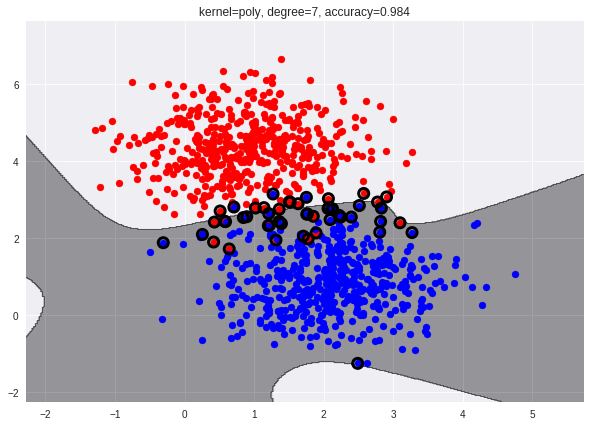

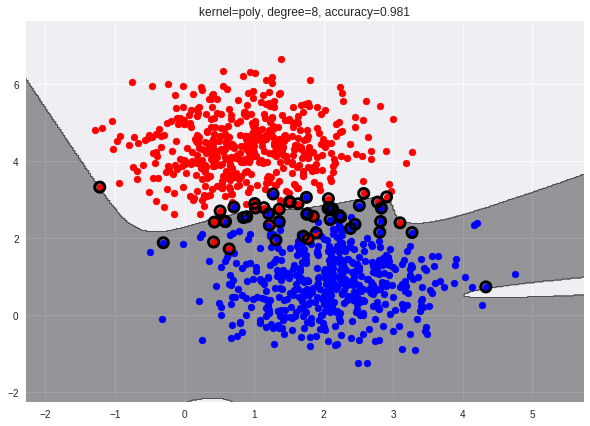

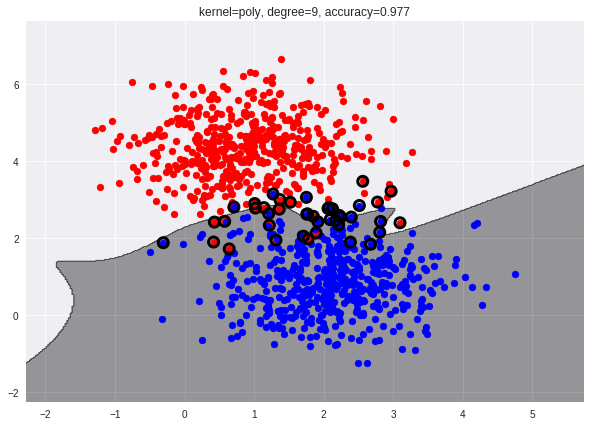

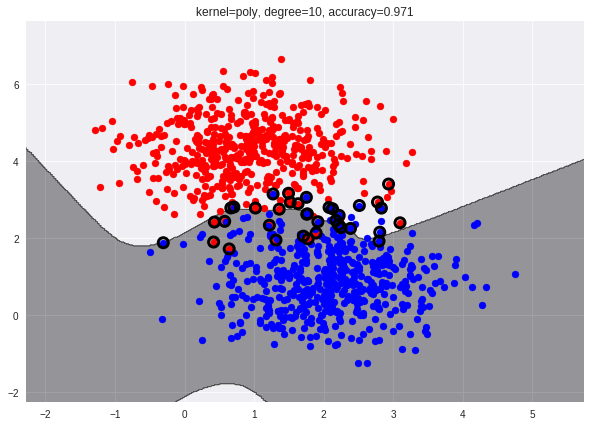

In [6]:
score = plot_polynomial(X, y, ['linear', 'rbf', 'poly'], range(2, 11))

In [3]:
def merge(dicts):
    res = {}
    for d in dicts:
        res.update(d)
    return res

def plot_train_test_error(X, y, params, verbose=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, stratify=y, random_state=42)
    combinations = [ merge([{key: value} for (key, value) in zip(params, values)]) for values in itertools.product(*params.values())]
    
    res = list()
    for idx, c in enumerate(tqdm(combinations)):
        if verbose:
            print c, '{}/{}'.format(idx+1, len(combinations))
        
        start = time.time()

        model = SVC(**c)
        model.fit(X_train, y_train)
        
        train_acc = accuracy_score(y_train, model.predict(X_train))
        test_acc = accuracy_score(y_test, model.predict(X_test))
        res.append((len(model.support_vectors_), train_acc, test_acc, np.abs(train_acc - test_acc)))  
        
        end = time.time()
        if verbose:
            print 'elapsed: {}s'.format(end - start)
    
    plt.figure(figsize=(15, 10))
    plt.scatter([r[0] for r in res], [r[1] for r in res], color='green', label='train accuracy')
    plt.scatter([r[0] for r in res], [r[2] for r in res], color='yellow', label='test accuracy')
    plt.scatter([r[0] for r in res], [r[3] for r in res], color='red', label='train-test diff')
    plt.legend()
    plt.title(params['kernel'])
    return res

In [4]:
data_cancer = pd.read_csv('data/cancer.csv')

In [5]:
X_cancer = data_cancer.drop(['label'], axis=1)
y_cancer = data_cancer['label'].as_matrix()

{'cache_size': 2000, 'kernel': 'poly', 'C': 0.050000000000000003, 'degree': 2, 'gamma': 'auto'} 1/18
elapsed: 22.7697489262s
{'cache_size': 2000, 'kernel': 'poly', 'C': 0.050000000000000003, 'degree': 3, 'gamma': 'auto'} 2/18
elapsed: 194.61187005s
{'cache_size': 2000, 'kernel': 'poly', 'C': 0.050000000000000003, 'degree': 2, 'gamma': 0.02} 3/18
elapsed: 104.538980007s
{'cache_size': 2000, 'kernel': 'poly', 'C': 0.050000000000000003, 'degree': 3, 'gamma': 0.02} 4/18
elapsed: 79.3230910301s
{'cache_size': 2000, 'kernel': 'poly', 'C': 0.050000000000000003, 'degree': 2, 'gamma': 0.013333333333333334} 5/18
elapsed: 36.6366760731s
{'cache_size': 2000, 'kernel': 'poly', 'C': 0.050000000000000003, 'degree': 3, 'gamma': 0.013333333333333334} 6/18
elapsed: 258.012634993s
{'cache_size': 2000, 'kernel': 'poly', 'C': 0.10000000000000001, 'degree': 2, 'gamma': 'auto'} 7/18
elapsed: 58.9207029343s
{'cache_size': 2000, 'kernel': 'poly', 'C': 0.10000000000000001, 'degree': 3, 'gamma': 'auto'} 8/18
ela

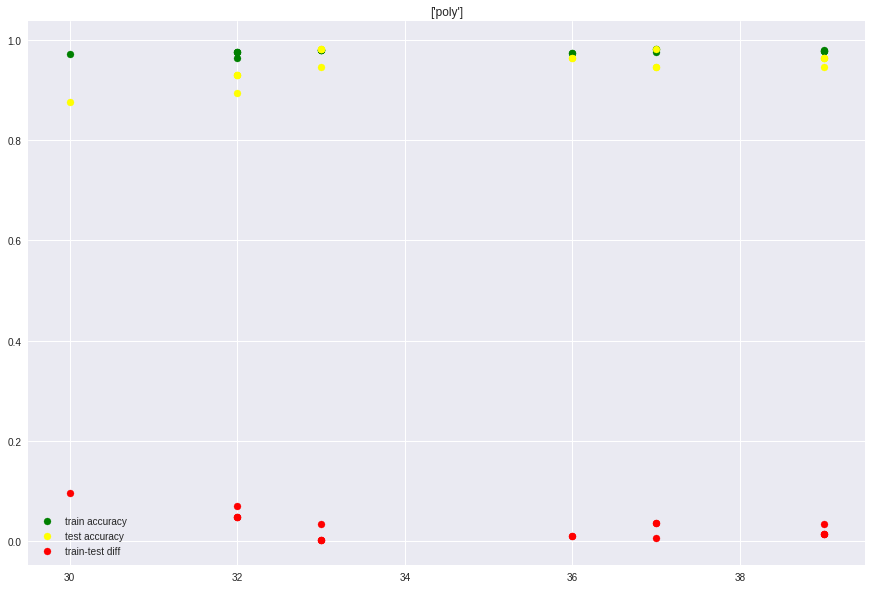

In [7]:
params = {"kernel":["poly"], "degree":[2,3], "C":np.arange(0.05, 0.19, 0.05), 'cache_size':[2000], 'gamma':['auto', 1./50, 1./75]}
plot_train_test_error(X_cancer, y_cancer, params)

100%|██████████| 99/99 [01:36<00:00,  1.37s/it]


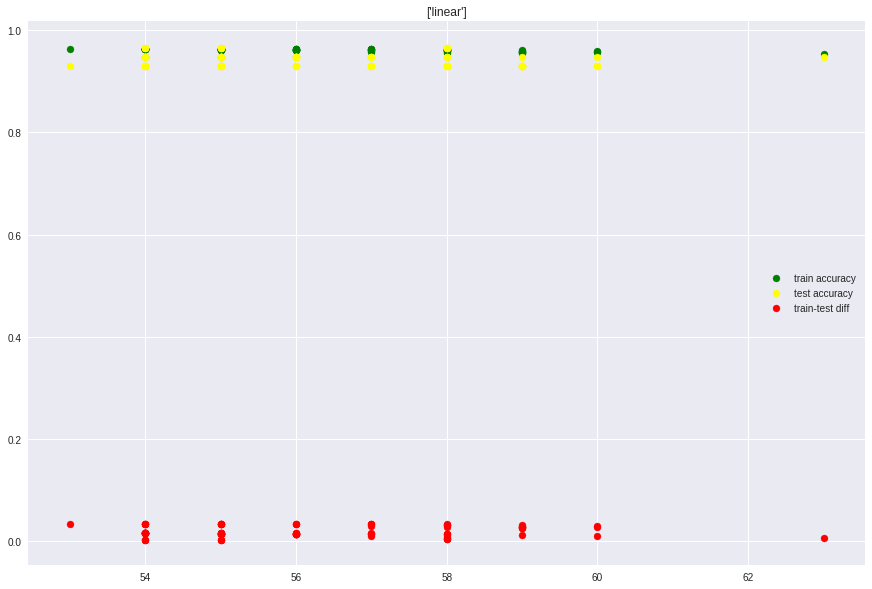

In [22]:
params = {"kernel":["linear"], "C":np.arange(0.01, 1., 0.01)}
plot_train_test_error(X_cancer, y_cancer, params)

100%|██████████| 1000/1000 [00:58<00:00, 16.37it/s]


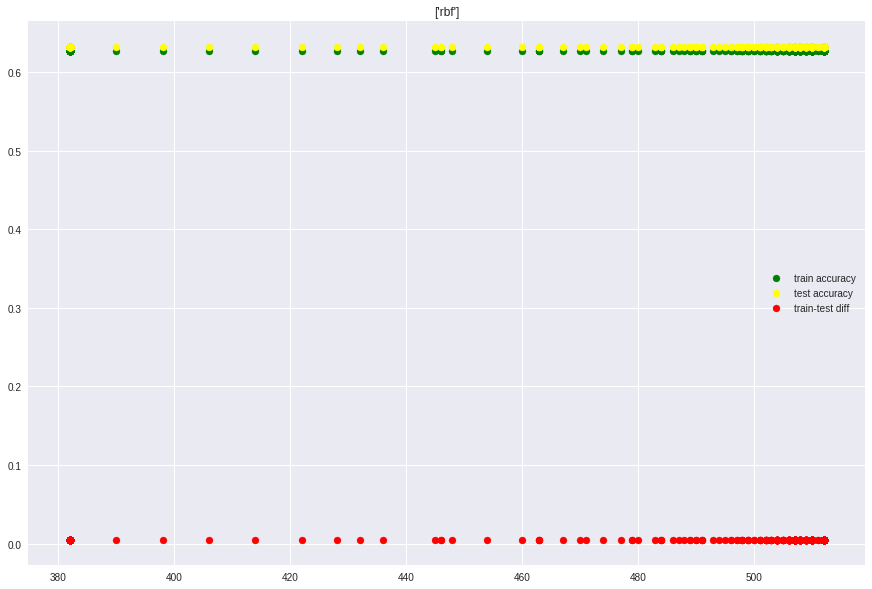

In [11]:
params = {"kernel":["rbf"], "C":np.arange(0.00005, 0.01, 0.0001), 'gamma':np.arange(0.01, 1./30, 0.0025) }
scores_rbf = plot_train_test_error(X_cancer, y_cancer, params, verbose=False)

In [19]:
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

In [7]:
cancer_trans = PCA(n_components=2).fit_transform(X_cancer)

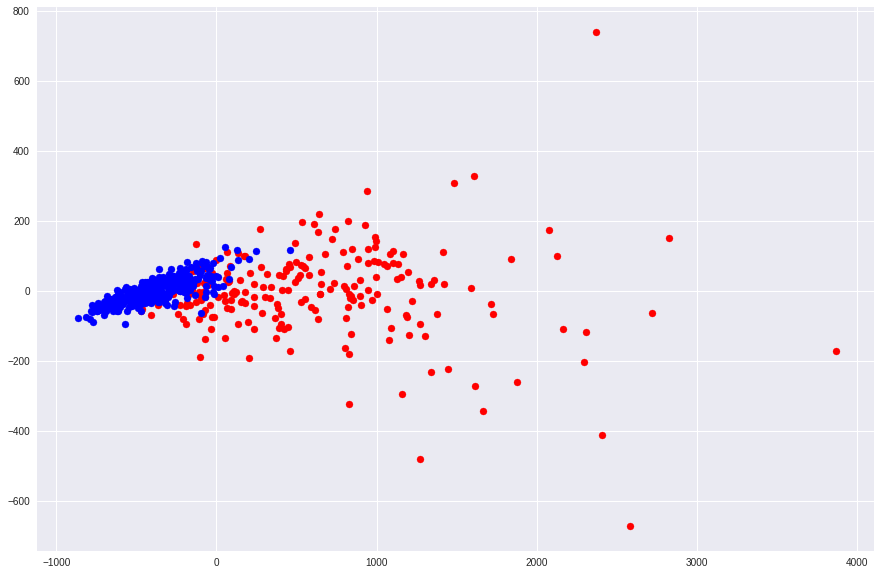

In [15]:
plt.figure(figsize=(15,10))
plt.scatter(cancer_trans[y_cancer == 'M'][:,0], cancer_trans[y_cancer == 'M'][:,1], color='red')
plt.scatter(cancer_trans[y_cancer == 'B'][:,0], cancer_trans[y_cancer == 'B'][:,1], color='blue')

In [17]:
cancer_trans = FastICA(n_components=2).fit_transform(X_cancer)

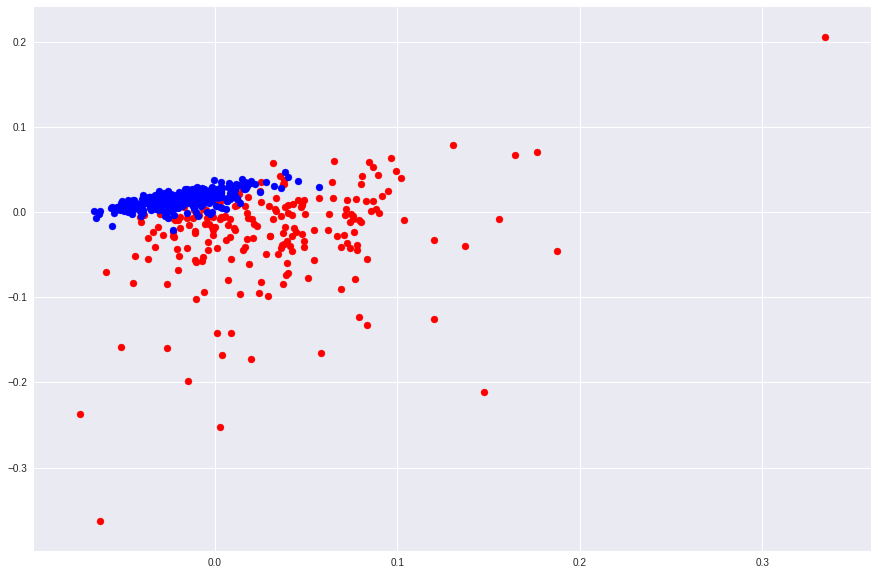

In [18]:
plt.figure(figsize=(15,10))
plt.scatter(cancer_trans[y_cancer == 'M'][:,0], cancer_trans[y_cancer == 'M'][:,1], color='red')
plt.scatter(cancer_trans[y_cancer == 'B'][:,0], cancer_trans[y_cancer == 'B'][:,1], color='blue')

In [21]:
cancer_trans = TSNE(n_components=2).fit_transform(X_cancer)

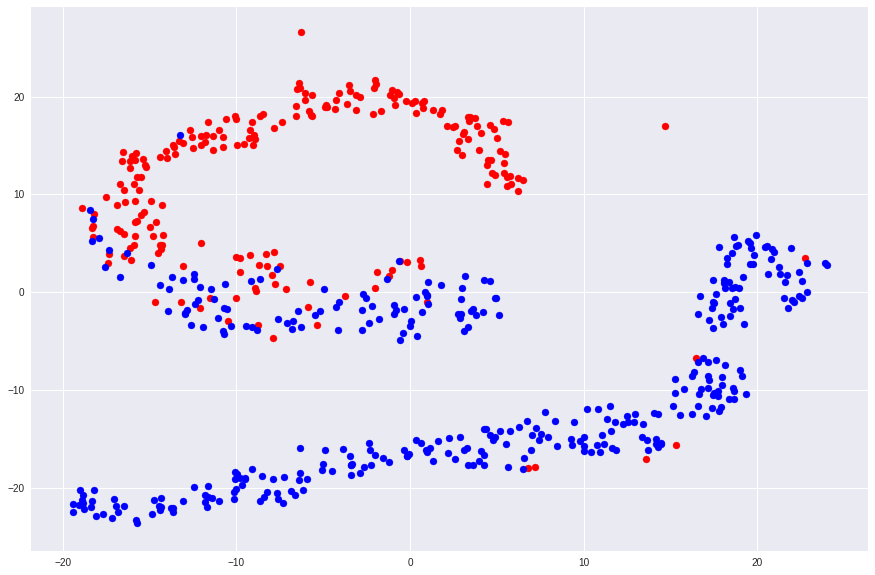

In [22]:
plt.figure(figsize=(15,10))
plt.scatter(cancer_trans[y_cancer == 'M'][:,0], cancer_trans[y_cancer == 'M'][:,1], color='red')
plt.scatter(cancer_trans[y_cancer == 'B'][:,0], cancer_trans[y_cancer == 'B'][:,1], color='blue')

In [6]:
# from pykernels.regular import *

In [13]:
# score = plot_polynomial(X, y, [Cossim(), Exponential(), Laplacian(), RationalQuadratic(), InverseMultiquadratic(),
#                               Cauchy(), TStudent(), ANOVA(), Wavelet(), Fourier(), Tanimoto(), Sorensen(),
#                               AdditiveChi2(), Chi2(), GeneralizedHistogramIntersection(), Spline()])